In [1]:
import json
import math
import random
from pathlib import Path
from pprint import pprint
from utils import load_dataset, create_dataset, write_test_data, gpt_prediction, eval_response, results_path

dataset, tag_counts = load_dataset("sentences.json")
print(len(dataset))
pprint(tag_counts)

200
{'all_lower': 78,
 'all_upper': 59,
 'animate': 1,
 'city': 25,
 'even_words': 97,
 'fragment_subject': 20,
 'fragment_verb': 20,
 'gpt4': 200,
 'long': 108,
 'long_margin': 60,
 'nature': 62,
 'odd_words': 103,
 'proper_noun': 32,
 'sentence': 160,
 'shared_sample': 42,
 'short': 92,
 'short_margin': 140,
 'start_cap': 121,
 'start_consonant': 171,
 'start_lower': 79,
 'start_the': 57,
 'start_vowel': 29}


In [2]:
# fragments vs sentence; just subject/verb fragments vs all; test if class balance changes accuracy
tags_true = ["city"]
tags_false = []
tags_common = []

output_dir = results_path / f"sentence_rare_{tags_true[0]}"
if not output_dir.exists():
    output_dir.mkdir(parents=True)


positives, negatives = create_dataset(dataset, tags_true, tags_false, tags_common, true_comb="AND", false_comb="AND")

with open(output_dir / "dataset_tags.txt", "w") as f:
    f.write(f"tags_true: {tags_true}\n")
    f.write(f"tags_false: {tags_false}\n")
    f.write(f"tags_common: {tags_common}\n")

print(len(positives), len(negatives))

25 175


In [3]:
pprint(positives)

[{'input': 'The Louvre Museum houses famous works of art.',
  'label': True,
  'tags': ['start_cap',
           'city',
           'long',
           'even_words',
           'proper_noun',
           'long_margin',
           'sentence',
           'start_consonant',
           'start_the',
           'gpt4']},
 {'input': 'The bustling city streets echoed with the sounds of honking horns '
           'and hurried footsteps.',
  'label': True,
  'tags': ['start_cap',
           'city',
           'long',
           'even_words',
           'long_margin',
           'sentence',
           'start_consonant',
           'start_the',
           'gpt4']},
 {'input': 'The Taj Mahal is a symbol of love.',
  'label': True,
  'tags': ['start_cap',
           'city',
           'long',
           'even_words',
           'proper_noun',
           'long_margin',
           'sentence',
           'start_consonant',
           'start_the',
           'gpt4']},
 {'input': 'The city at night resemble

In [4]:
pprint(negatives)

[{'input': 'the mountains are majestic and grand.',
  'label': False,
  'tags': ['shared_sample',
           'even_words',
           'nature',
           'short',
           'sentence',
           'start_lower',
           'start_consonant',
           'start_the',
           'short_margin',
           'gpt4',
           'all_lower']},
 {'input': 'the world is full of fascinating cultures.',
  'label': False,
  'tags': ['long',
           'odd_words',
           'sentence',
           'start_lower',
           'start_consonant',
           'start_the',
           'short_margin',
           'gpt4',
           'all_lower']},
 {'input': 'Green smoothies are a nutritious breakfast option.',
  'label': False,
  'tags': ['start_cap',
           'long',
           'odd_words',
           'start_consonant',
           'short_margin',
           'sentence',
           'gpt4']},
 {'input': "LIFE IS WHAT HAPPENS WHEN YOU'RE BUSY MAKING PLANS.",
  'label': False,
  'tags': ['start_cap',
         

In [6]:
sample_counts = [3, 5, 10, 15]
response_jsons = []
sort_len = lambda x: len(x.split())
for c in sample_counts:
    write_test_data(positives, negatives, c, output_dir, unbalanced=True, max_test_ct=70, tiled=True, prompt_sort_by=sort_len)
    in_context_prompt = open(output_dir / f"in_context_prompt_{c}.txt").read()
    test_prompt = open(output_dir / f"test_prompt_{c}.txt").read()
    test_samples = json.load(open(output_dir / f"test_samples_{c}.json"))
    response_json = gpt_prediction(in_context_prompt, test_prompt, json_mode=True)
    json.dump(response_json, open(output_dir / f"response_{c}.json", "w"))
    response_jsons.append(response_json)

/Users/ishangaur/classification-faithfulness/utils.py:106: UserWarning: json_mode only supported for gpt-4-1106-preview
  warn("json_mode only supported for gpt-4-1106-preview")
/Users/ishangaur/classification-faithfulness/utils.py:107: UserWarning: changing model to gpt-4-1106-preview
  warn("changing model to gpt-4-1106-preview")
/Users/ishangaur/classification-faithfulness/utils.py:110: UserWarning: json_mode is on but user_query does not contain "json"
  warn("json_mode is on but user_query does not contain \"json\"")
/Users/ishangaur/classification-faithfulness/utils.py:111: UserWarning: adding prefix to user_query:
"Please label the following inputs. Respond in JSON format like the examples given to you above."
  warn(f"adding prefix to user_query:\n\"{json_prefix}\"")
/Users/ishangaur/classification-faithfulness/utils.py:106: UserWarning: json_mode only supported for gpt-4-1106-preview
  warn("json_mode only supported for gpt-4-1106-preview")
/Users/ishangaur/classification-fait

In [7]:
sample_counts = [3, 5, 10, 15]
response_jsons = [json.load(open(output_dir / f"response_{c}.json")) for c in sample_counts]
test_samples = [json.load(open(output_dir / f"test_samples_{c}.json")) for c in sample_counts]

results = []
responses = []
for r, t in zip(response_jsons, test_samples):
    response, result = eval_response(r, t)
    results.append(result)
    responses.append(response)

In [8]:
for c, r in zip(sample_counts, results):
    r["in_context_count"] = c
pprint(results)

[{'accuracy': 0.75,
  'correct': 69,
  'corrupted': 0,
  'false_neg': 1,
  'false_pos': 48,
  'in_context_count': 3,
  'incorrect': 23,
  'mismatch': 0,
  'total': 92,
  'true_neg': 22,
  'true_pos': 21},
 {'accuracy': 0.8888888888888888,
  'correct': 80,
  'corrupted': 0,
  'false_neg': 2,
  'false_pos': 62,
  'in_context_count': 5,
  'incorrect': 10,
  'mismatch': 0,
  'total': 90,
  'true_neg': 8,
  'true_pos': 18},
 {'accuracy': 0.8705882352941177,
  'correct': 74,
  'corrupted': 0,
  'false_neg': 8,
  'false_pos': 67,
  'in_context_count': 10,
  'incorrect': 11,
  'mismatch': 0,
  'total': 85,
  'true_neg': 3,
  'true_pos': 7},
 {'accuracy': 0.85,
  'correct': 68,
  'corrupted': 0,
  'false_neg': 0,
  'false_pos': 58,
  'in_context_count': 15,
  'incorrect': 12,
  'mismatch': 0,
  'total': 80,
  'true_neg': 12,
  'true_pos': 10}]


In [9]:
json.dump(responses, open(output_dir / "responses.json", "w"))
json.dump(results, open(output_dir / "results.json", "w"))

   correct  mismatch  incorrect  corrupted  total  true_pos  true_neg  \
0       69         0         23          0     92        21        22   
1       80         0         10          0     90        18         8   
2       74         0         11          0     85         7         3   
3       68         0         12          0     80        10        12   

   false_pos  false_neg  in_context_count  
0         48          1                 3  
1         62          2                 5  
2         67          8                10  
3         58          0                15  
                   correct  mismatch  incorrect  corrupted   true_pos  \
in_context_count                                                        
3                 0.750000       0.0   0.250000        0.0  21.684783   
5                 0.888889       0.0   0.111111        0.0  19.000000   
10                0.870588       0.0   0.129412        0.0   7.823529   
15                0.850000       0.0   0.150000  

Text(0.5, 1.0, 'Short (<7) vs Long Tiled (n=95, T=1)')

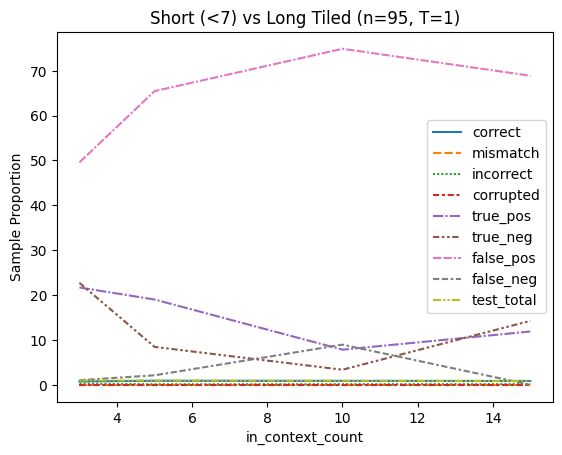

In [13]:
import pandas as pd
import seaborn as sns

results = json.load(open(output_dir / "results.json"))

df = pd.DataFrame(results)
df.drop(columns=["accuracy"], inplace=True)
total_samples = df["total"].max() + df["in_context_count"].min()

print(df)
for col in df.columns:
    if col == "total":
        continue
    elif col == "in_context_count":
        continue
    else:
        df[col] /= df["total"]
df["total"] /= total_samples
df["test_total"] = df["total"]
df.drop(columns=["total"], inplace=True)
df.set_index("in_context_count", inplace=True)
print(df)

ax = sns.lineplot(data=df)
ax.set_ylabel("Sample Proportion")
ax.set_title(f"Short (<7) vs Long Tiled (n={total_samples}, T=1)")